<a href="https://colab.research.google.com/github/SophieD517/MTL/blob/main/Exponential%20Decay/ExponentialDecay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Objectives**
1.   Can multitask learning models make reasonably accurate predictions about the features of graphs when compared to conventional artificial neural networks?
2.   When trained using a multitask learning approach, are features of graphs directly encoded within the latent space?
3.   Does the number of variables in an equation correlate with the latent dimension that yields optimal reconstruction and predictions?



In [29]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader as dl
import math as m

# https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

## Generate Data
Let us begin with some toy data. We have exponential decay curves created through the first-order decay equation  

  $N(t) = N_{0}e^{\frac{t}{t_{1/2}}}$

where $t_{1/2}$ represents the time required for half of the sample to decay. Below we illustrate the distribution of half-lives used as well as the graphs drawn as a function of $t$.

Since that each curve is dependent solely on the value of $t_{1/2}$, we can draw the assumption that a compressed representation of each curve should consist of only one data point, which should correspond directly to $t_{1/2}$.

In [ ]:
half_lives = np.random.uniform(low=10e-3, high=10e2, size = 10000).tolist()
rows = []
for half_life in half_lives:
  rows.append([0.5**(t/half_life) for t in range(100)])
data = pd.DataFrame(rows)
data['half_life'] = half_lives

In [43]:
def load_data():
  test = pd.read_csv('/content/test.csv').drop(columns='Unnamed: 0')
  train = pd.read_csv('/content/train.csv').drop(columns='Unnamed: 0')
  val = pd.read_csv('/content/validate.csv').drop(columns='Unnamed: 0')
  X = torch.tensor(train.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y = torch.tensor(train['half_life'].values, requires_grad=True, dtype=torch.float32)
  X_test = torch.tensor(test.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y_test = torch.tensor(test['half_life'].values, requires_grad=True, dtype=torch.float32)
  X_val = torch.tensor(val.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y_val = torch.tensor(val['half_life'].values, requires_grad=True, dtype=torch.float32)
  return X, Y, X_test, Y_test, X_val, Y_val

[Text(0.5, 1.0, 'Half-life Distribution')]

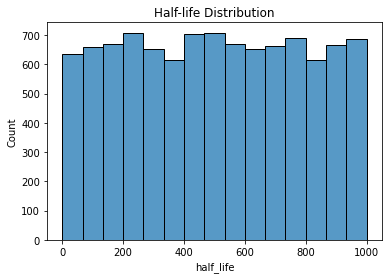

In [ ]:
sns.histplot(data=data, x='half_life', bins=15).set(title='Half-life Distribution')

Text(0.5, 1.0, 'Fraction Substance Remaining Over Time')

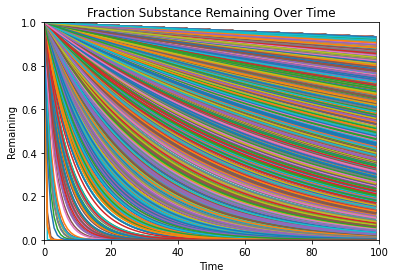

In [ ]:
x = np.arange(100)
y = data.drop(columns=['half_life'])
for index, row in y.iterrows():
  plt.plot(x, row)
plt.ylabel('Remaining')
plt.xlabel('Time')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.title('Fraction Substance Remaining Over Time')

In [ ]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
msk2 = np.random.rand(len(test)) < 0.8
validate = test[~msk2]
test = test[msk2]
train.to_csv('/content/train.csv')
test.to_csv('/content/test.csv')
validate.to_csv('/content/validate.csv')

#Neural Network


*   fully connected, linear layers
*   proves that $t_{1/2}$ is a discernible feature of the function N(t)


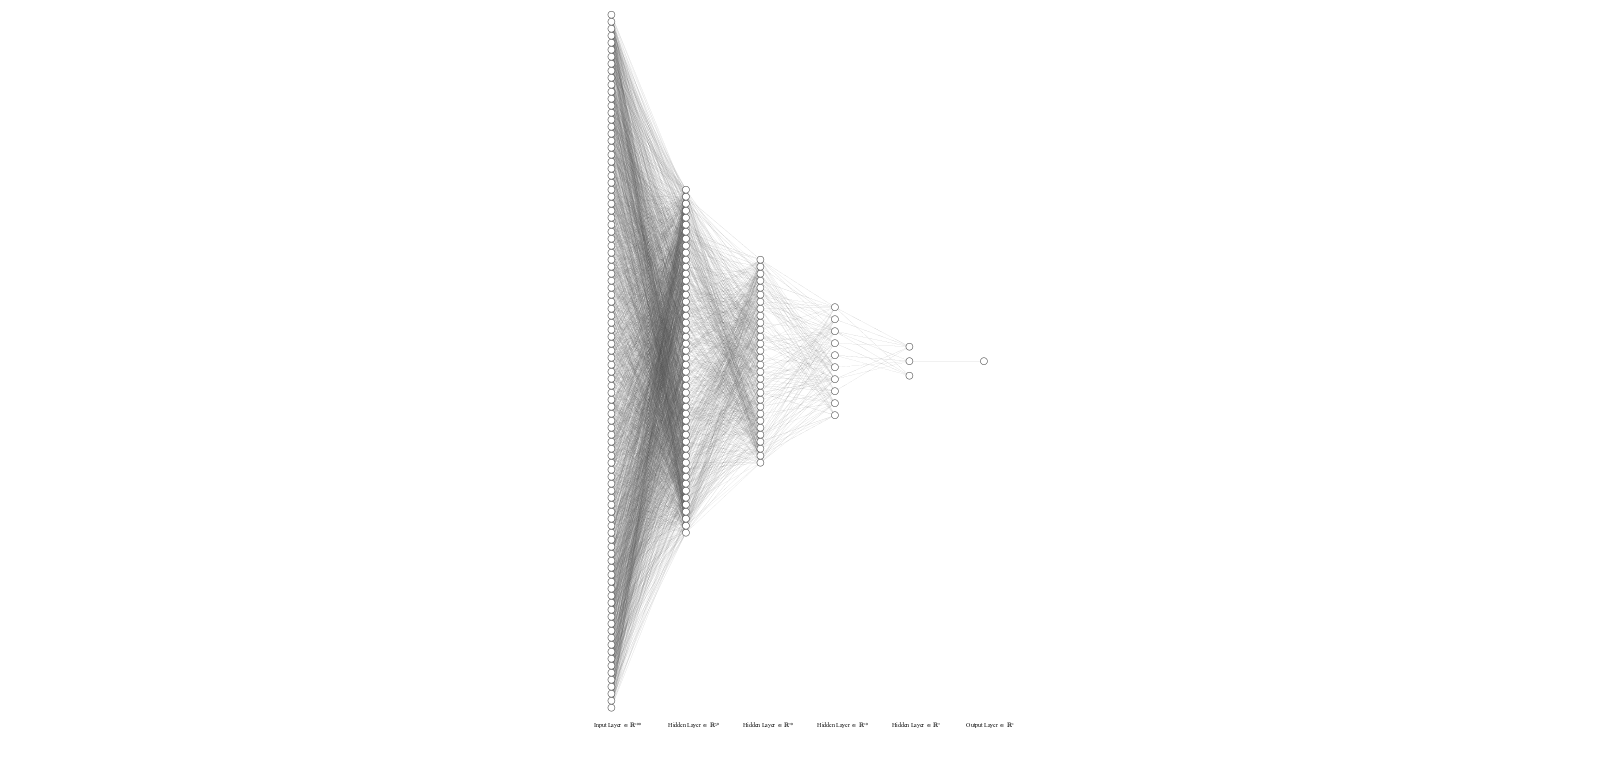

In [40]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.neural_net = torch.nn.Sequential(
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 1)
        )

    def forward(self, x):
        return self.neural_net(x)

In [73]:
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

def train(epochs, x, y, val_x, val_y):
  dataloader = FastTensorDataLoader(x, y, shuffle=True)
  for epoch in range(epochs):
    for idx, data in enumerate(dataloader):
      optimizer.zero_grad()
      pred = model(data[0])
      loss = torch.nn.MSELoss()(pred.squeeze(), data[1].squeeze())
      losses.append(loss.detach().numpy())
      loss.backward(retain_graph=True)
      optimizer.step()
    print(f'loss: {loss.mul(0.1)}, val loss: {torch.nn.MSELoss()(model(val_x).squeeze(), val_y.squeeze()).mul(0.1)}')

def save():
  torch.save(model.state_dict(), 'nn.zip')

def graph_loss():
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  x = np.arange(len(losses))
  y = losses
  plt.plot(x, y, color='purple')
  plt.xlim(0)
  plt.ylim(0)

def indiv_loss(xt, yt):
  losses = []
  df = test(xt, yt)
  preds = torch.tensor(df['predicted'])
  dataloader = FastTensorDataLoader(preds, yt, batch_size=1, shuffle=False)
  for idx, row in enumerate(dataloader):
    losses.append(torch.nn.MSELoss()(row[0], row[1]).item())
  return losses

def test(x_test, y_test):
  weights = torch.load('/content/nn.zip')
  model.load_state_dict(weights)
  model.eval()
  pred = model(x_test)
  loss = torch.nn.MSELoss()(pred.squeeze(), y_test.squeeze())
  test_df = pd.DataFrame({'half_life': y_test.detach().numpy()})
  test_df['predicted'] = [item for sublist in pred.tolist() for item in sublist]
  test_df['percent_error'] = 100*(test_df['predicted'] - test_df['half_life'])/test_df['half_life']
  return test_df

def loss_hist(xt, yt):
  fig, ax = plt.subplots()
  print(len(indiv_loss(xt, yt)))
  sns.histplot(data=indiv_loss(xt, yt), ax=ax)
  ax.set_xlim(0)
  plt.title('loss distribution')
  plt.show()

def graph_results(xt, yt, num=1000):
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  sample_df = test(xt, yt).sample(n=num)
  y = sample_df['half_life']
  x = sample_df['predicted']
  plt.scatter(x, y, color='blue', s=.1)
  plt.plot(x, x, color='gray', linewidth=.3)
  plt.xlim(0, 1000)
  plt.ylim(0, 1000)

loss: 4708.24462890625, val loss: 5369.90771484375
loss: 4801.92919921875, val loss: 4952.35888671875
loss: 4232.650390625, val loss: 4141.3896484375
loss: 2761.744873046875, val loss: 2550.872802734375
loss: 1330.2103271484375, val loss: 1270.824951171875
loss: 589.9298095703125, val loss: 718.63818359375
loss: 438.4933776855469, val loss: 425.5592346191406
loss: 310.06341552734375, val loss: 270.9248046875
loss: 93.44294738769531, val loss: 218.7743377685547
loss: 199.06687927246094, val loss: 136.8756866455078
loss: 77.4345474243164, val loss: 94.9474868774414
loss: 96.9732437133789, val loss: 125.7940444946289
loss: 72.9672622680664, val loss: 53.204681396484375
loss: 25.035526275634766, val loss: 42.50030517578125
loss: 14.090921401977539, val loss: 43.91030502319336
loss: 27.524763107299805, val loss: 46.96255111694336
loss: 18.845979690551758, val loss: 38.210941314697266
loss: 15.775506973266602, val loss: 31.276453018188477
loss: 5.302682399749756, val loss: 15.117189407348633

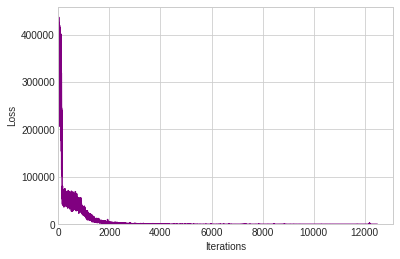

In [58]:
x, y, xt, yt, xv, yv = load_data()
train(50, x, y, xv, yv)
save()
graph_loss()

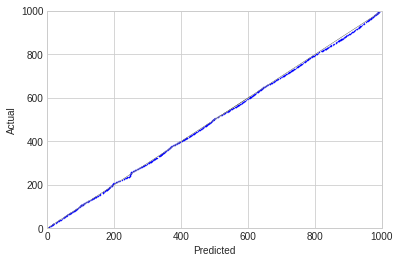

In [74]:
graph_results(xt, yt)

1641


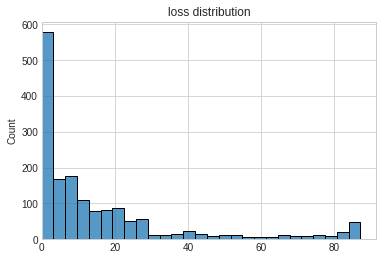

In [75]:
loss_hist(xt, yt)

# Autoencoder
* proof of ability to perform dimensionality reduction on data
* 

In [ ]:
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(100, 70),
      torch.nn.ReLU(),
      torch.nn.Linear(70, 40),
      torch.nn.ReLU(),
      torch.nn.Linear(40, 20),
      torch.nn.ReLU(),
      torch.nn.Linear(20, 10),
      torch.nn.ReLU(),
      torch.nn.Linear(10, 2)
    )
    self.decoder = torch.nn.Sequential( 
      torch.nn.ReLU(),
      torch.nn.Linear(2, 10),
      torch.nn.ReLU(),
      torch.nn.Linear(10, 20),
      torch.nn.ReLU(),
      torch.nn.Linear(20, 40),
      torch.nn.ReLU(),
      torch.nn.Linear(40, 70),
      torch.nn.ReLU(),
      torch.nn.Linear(70, 100),
      torch.nn.Sigmoid()
    )

  def forward(self, x):
    latent_space = self.encoder(x)
    return self.decoder(latent_space)